Link to original opensees website for the problem:
https://opensees.berkeley.edu/wiki/index.php/OpenSees_Example_2b._Nonlinear_Cantilever_Column:_Uniaxial_Inelastic_Section

**We will be performing 3 different analysis**
- Gravity Analysis
- Monotonic Pushover
- Time History Analysis

**------------Static Pushover-------**
<img src="https://opensees.berkeley.edu/wiki/images/5/58/Example2b_Push.GIF" align="left"></img>
**-------Dynamic Earthquake---------**
<img src="https://opensees.berkeley.edu/wiki/images/5/5b/Example2b_EQ.GIF" align="right"></img>

## Units conversion

In [10]:
#length conversion
m = 1.0
inch = m/39.37
ft = 12*inch 

#area conversion
sqinch = inch**2

#ksi to pa
pa = 1.0
kpa = 1000*pa
ksi = 6.89*1000*kpa

#kip to kN
N = 1.0
kN = 1000 * N
kip = 4.45 * kN

# pound to kg
kg = 1 
pound = 0.453592 * kg


In [11]:
2000 * kip / 9.81

907237.5127420998

## Model Variables

In [12]:
h = 432 #inch #col height

#section of column
b = 60.0 # inch #width of section
d = 60.0 #inch #depth of section

Acol = b*d*1000  #section area
Iz = 1.0/12.0*b*d**3  #moi of section
E = 3225  #*ksi  #modulus of elasticity

#weight
w = 2000 #Kip
Pcol = w #load applied on column (gravity load)
mass = w/386.4 #nodal mass

#analysis names
gravityAnalysis = 'GravityAnalysis'
pushoverAnalysis = 'PushoverAnalysis'
timeHistory = 'TimeHistoryAnalysis'

## Model Definition

In [13]:
import openseespy.opensees as ops
import opsvis as ovs
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def getModel():
    ops.wipe()
    ops.model('BasicBuilder', '-ndm', 2, '-ndf', 3)

    ops.node(1, 0, 0)
    ops.node(2, 0, h)

    ops.fix(1, 1, 1, 1)
    

    #Mass is assigned at node 2 using mass command. 
    #Since transient analysis is going to be performed for one component of ground motion (horizontal component - x direction),
    #the mass is to be assigned in x direction. 
    #The mass is defined as Weight/g=2000/386=5.18. The vertical and rotational mass are set to zero.
    ops.mass(2, *[mass, 1e-9, 0])

    #Section and element definition
    ColMatTagFlex = 2 # tag number to column flexural behaviour
    ColMatTagAxial = 3 #tag number to column axial behaviour
    ColSecTag = 1 #tag number to column section tag
    BeamSecTag = 2 #tag number to beam section tag

    #material parameters
    fc = -4 #concrete compressive strength
    Ec = 57 * np.sqrt(-fc * 1000) #concrete elastic modulus

    #column section
    #calculated stiffness parameters
    EICol = Ec * Iz  #EI for moment curvature relationship
    EACol = Ec * Acol #EA for axial force strain relationship
    MyCol = 130000 #yield moment
    PhiYCol = 0.65e-4 #yeild curvature
    EIColCrack = MyCol/PhiYCol #cracked section inertia
    b = 0.01 #strain hardening ratio (ratio between post-yield tangent and initial elastic tangent)

    ops.uniaxialMaterial('Steel01', ColMatTagFlex, MyCol, EIColCrack, b)
    ops.uniaxialMaterial('Elastic', ColMatTagAxial, EACol)
    #section('Aggregator', secTag, *mats, '-section', sectionTag)
    ops.section('Aggregator', ColSecTag, ColMatTagAxial, 'P', ColMatTagFlex, 'Mz')

    
    linTransf = 1
    pDelta = 2
    ops.geomTransf('Linear', linTransf)

    numIntgrPts = 5
    #element('nonlinearBeamColumn', eleTag, *eleNodes, numIntgrPts, secTag, transfTag, '-iter', maxIter=10, tol=1e-12, '-mass', mass=0.0, '-integration', intType)
    ops.element('nonlinearBeamColumn', 1, *[1,2], numIntgrPts, ColSecTag, linTransf)

In [20]:
def getRecorders(AnalysisName):
    numIntgrPts = 5
    ops.recorder("Node", '-file', f"Outputs/{AnalysisName}/DispFree.txt", '-time', '-closeOnWrite', '-node', 2,'-dof', *[1,2,3], 'disp')
    ops.recorder("Node", '-file', f"Outputs/{AnalysisName}/DispSupport.txt", '-time', '-closeOnWrite', '-node', 1,'-dof', *[1,2,3], 'disp')
    ops.recorder("Node", '-file', f"Outputs/{AnalysisName}/ReactionsSupport.txt", '-time', '-closeOnWrite', '-node', 1,'-dof', *[1,2,3], 'reaction')

    #ops.recorder('Drift', '-file', "Outputs/Drifts.txt", '-time', '-closeOnWrite', '-inode', 1, '-jnode', 2, '-dof', 1, '-perpDirn', 2)

    #recorder Element -file Data/FCol.out -time -ele 1 force
    ops.recorder('Element', '-file', f'Outputs/{AnalysisName}/ForcesColumn.txt', '-time', '-closeOnWrite', '-ele', 2, 'globalForce')
    ops.recorder('Element', '-file', f'Outputs/{AnalysisName}/ForceColSec1.txt', '-time', '-closeOnWrite', '-ele', 1, 'section', 1, 'force')				# Column section forces, axial and moment, node i
    ops.recorder('Element', '-file', f'Outputs/{AnalysisName}/DefoColSec1.txt', '-time', '-closeOnWrite', '-ele', 1, 'section', 1, 'deformation')				# section deformations, axial and curvature, node i
    ops.recorder('Element', '-file', f'Outputs/{AnalysisName}/ForceColSec{numIntgrPts}.txt', '-time', '-closeOnWrite', '-ele', 1, 'section', numIntgrPts, 'force')	# section forces, axial and moment, node j
    ops.recorder('Element', '-file', f'Outputs/{AnalysisName}/DefoColSec{numIntgrPts}.txt', '-time', '-closeOnWrite', '-ele', 1, 'section', numIntgrPts, 'deformation')	# section deformations, axial and curvature, node j


Since the analysis is static and specific load (2000 kips) is to be applied, load control integrator will be used in this example. The load factor increment ($\lambda$) is set to 0.1 since the full load of 2000 kips is to be applied in 10 analysis steps. For the nth step of analysis the load factor is $\lambda_n = \lambda_{n-1} + \lambda$

In [21]:
def runGravityAnalysis():
    tol = 1e-8
    NstepGravity = 10
    DGravity = 1./NstepGravity
    linTS = 1
    ops.timeSeries("Linear", linTS) #tag 1 for linear time series

                        #pattern tag #ts tag
    ops.pattern("Plain", 1, linTS)
    ops.load(2, *[0, -Pcol, 0])

    ops.constraints("Plain")
    ops.numberer("Plain")
    ops.system("BandGeneral")
    ops.test("NormDispIncr", tol, 6)
    ops.algorithm("Newton")
    ops.integrator("LoadControl", DGravity)
    ops.analysis("Static")

    ops.record()
    result = ops.analyze(NstepGravity) #10 steps of analysis to reach load of py
    return result

In [27]:
def runPushoverAnalysis():
    ops.loadConst('-time', 0.0)
    DcontrolNode = 2
    DcontrolDof = 1
    Dmax = 0.05*h
    Dincr = 0.01*h

    HLoad = w

    linTS = 1
                        #pattern tag #ts tag
    ops.pattern("Plain", 200, linTS)
    ops.load(2, *[HLoad, 0.0, 0.])

    tol = 1.e-8
    maxNumIter = 6
    
    ops.constraints("Plain")
    ops.numberer("Plain")
    ops.system("BandGeneral")
    ops.test("EnergyIncr", tol, maxNumIter, 0)
    ops.algorithm("Newton")
    ops.integrator("DisplacementControl", DcontrolNode, DcontrolDof, Dincr)
    ops.analysis("Static")

    ops.record()
    Nstep = int(Dmax/Dincr)
    result = ops.analyze(Nstep) #10 steps of analysis to reach load of py
    return result

In [33]:
getModel()
getRecorders(gravityAnalysis)
runGravityAnalysis()

0

Text(0.5, 1.0, 'Model with deformation')

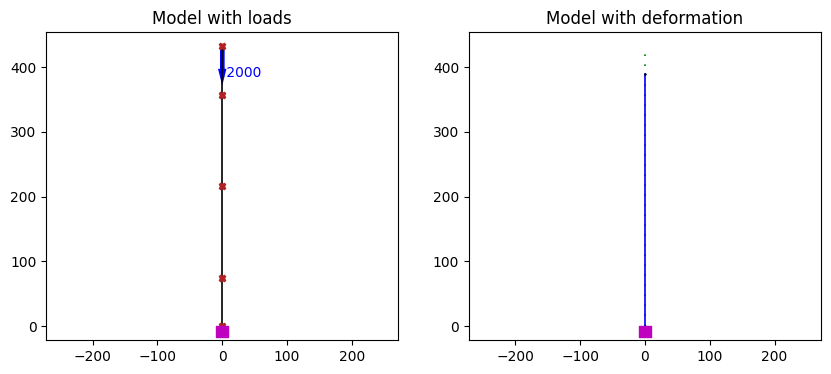

In [34]:
fig, ax = plt.subplots(1, 2 , figsize=(10,4))
ovs.plot_loads_2d(ax=ax[0])
ovs.plot_defo(ax=ax[1])
ax[0].set_title("Model with loads")
ax[1].set_title("Model with deformation")

## Pushover Analysis

In [35]:
getModel()
getRecorders(pushoverAnalysis)
runGravityAnalysis()
runPushoverAnalysis()

WARNING can't set handler after analysis is created


0

Text(0.5, 1.0, 'Model with deformation')

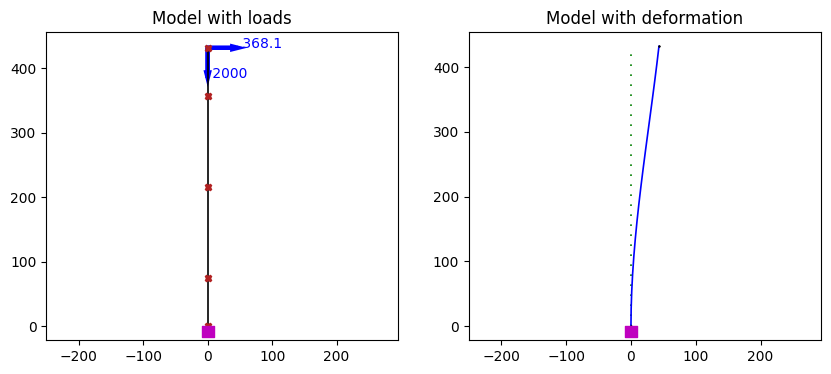

In [36]:
fig, ax = plt.subplots(1, 2 , figsize=(10,4))
ovs.plot_loads_2d(ax=ax[0])
ovs.plot_defo(ax=ax[1])
ax[0].set_title("Model with loads")
ax[1].set_title("Model with deformation")